In [1]:
%matplotlib inline
#imports
import nest
import yaml
import nest.raster_plot
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram, butter, filtfilt
from analysis_functions import *
from asserting_functions import *
from yaml_io import *
from prepare_nest_parameters import *
from nest_reset_create_connect_simulate import *
from activity_analysis import *
from synaptic_io import *


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.7.0
 Built: Jun 14 2024 10:44:24

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
is_verbose = False
#copy configuration yamls in specified output directory
directories_and_list_of_yamls =\
    read_basic_directories_and_list_of_yamls(is_verbose)
output_dir_name = copy_yamls_in_output_dir(directories_and_list_of_yamls, is_verbose)

is_verbose = True
#total sim, resolution and recording times
times = read_sim_and_recording_times_yaml(is_verbose)

#read general network parameters
config = read_general_config_yaml(is_verbose)

#copy neu_params_yamls in output directory
copy_neu_params_yamls_in_output_dir(output_dir_name, config, is_verbose)

#prepare all simulation parameters
nest_pms={}
nest_pms = nest_parameters_preparation(times, config, is_verbose, nest_pms)
print("nest_pms",nest_pms)

in read_directories_yaml: verbose mode is False
in read_sim_and_recording_times_yaml: verbose mode is True
IN read_sim_and_recording_times_yaml:
opening file: basic_sim_and_recording_times.yaml
DEFAULT CONFIG (possibly to be TUNED): {'sim_pms': {'stop_ms': 45000.0, 'resolution_ms': 0.1}, 'recording_pms': {'start_ms': 5000.0, 'stop_ms': 45000.0}, 'events_pms': [{'action': {'kind': 'store_syn', 'syn_file_name': 'syn_matrix-initial'}, 'sim_period_ms': 10000.0}, {'action': {'kind': 'exc_plasticity_ON', 'target_exc_pop': 0, 'W_max_factor': 2.0}, 'sim_period_ms': 500.0}, {'action': {'kind': 'store_syn', 'syn_file_name': 'syn_matrix-after_learning-0-10500ms'}, 'sim_period_ms': 500.0}, {'action': {'kind': 'store_syn', 'syn_file_name': 'syn_matrix-after_learning-0-11000ms'}, 'sim_period_ms': 1000.0}, {'action': {'kind': 'store_syn', 'syn_file_name': 'syn_matrix-after_learning-0-12000ms'}}, {'action': {'kind': 'exc_plasticity_ON', 'target_exc_pop': 1, 'W_max_factor': 2.0}, 'sim_period_ms': 500.0

In [3]:
NEST_version = nest.__version__
if NEST_version == "3.7.0" and nest_pms["use_single_compartment_environment"]==False:
    print("ASSERTION ERROR: Ca-AdEx multi-compartment neuron not supported by this NEST version", NEST_version)
    assert(False)

In [4]:
is_verbose=False
num_threads=4
sim_completed, spike_recorders, inh_spike_recorder, multimeters, list_of_syn_matrix_file_names =\
    nest_reset_create_connect_simulate(nest_pms,num_threads, is_verbose)
print("sim_completed", sim_completed)

IN nest_reset_create_connect_simulate: use_single_compartment_environment =
Oct 18 18:41:19 SimulationManager::set_status [Info]: 
 True
in nest_..._simulate: just before nest.Simulate
ACTION {'kind': 'store_syn', 'syn_file_name': 'syn_matrix-initial'}
expected NEXT SIM PERIOD ms 20000.0
ACTION {'kind': 'exc_plasticity_ON', 'target_exc_pop': 0, 'W_max_factor': 2.0}
expected NEXT SIM PERIOD ms 500.0
ACTION {'kind': 'store_syn', 'syn_file_name': 'syn_matrix-after_learning-0-10500ms'}
expected NEXT SIM PERIOD ms 500.0
ACTION {'kind': 'store_syn', 'syn_file_name': 'syn_matrix-after_learning-0-11000ms'}
expected NEXT SIM PERIOD ms 1000.0
ACTION {'kind': 'store_syn', 'syn_file_name': 'syn_matrix-after_learning-0-12000ms'}
ACTION {'kind': 'exc_plasticity_ON', 'target_exc_pop': 1, 'W_max_factor': 2.0}
expected NEXT SIM PERIOD ms 500.0
ACTION {'kind': 'store_syn', 'syn_file_name': 'syn_matrix-after_learning-1-12500ms'}
expected NEXT SIM PERIOD ms 500.0
ACTION {'kind': 'store_syn', 'syn_file_nam

/opt/anaconda3/envs/nest_env/lib/python3.12/site-packages/nest/lib/hl_api_helper.py:114: UserWarning:
Models is deprecated and will be removed in a future version of NEST.
Please use nest.node_models or nest.synapse_models instead!


In [5]:
d_inh = nest.GetStatus(inh_spike_recorder, "events")[0]

In [6]:
#before analysis, preliminary sim look 
is_verbose=True
preliminary_sim_look(is_verbose, nest_pms, spike_recorders, inh_spike_recorder, nest_pms["recording_pms"])   

pop 0 first recorded event at time 95.10000000000001 from sender 20
pop 0 last recorded event at time 19991.3 from sender 19
pop 0 total_exc_pop_spikes = 1278
pop 0 average_exc_pop_firing_rate_Hz = 3.1950000000000003 Hz
pop 1 first recorded event at time 27.7 from sender 32
pop 1 last recorded event at time 19949.600000000002 from sender 27
pop 1 total_exc_pop_spikes = 1265
pop 1 average_exc_pop_firing_rate_Hz = 3.1625 Hz
pop 2 first recorded event at time 24.0 from sender 48
pop 2 last recorded event at time 19995.5 from sender 47
pop 2 total_exc_pop_spikes = 1273
pop 2 average_exc_pop_firing_rate_Hz = 3.1825 Hz
pop 3 first recorded event at time 64.9 from sender 68
pop 3 last recorded event at time 19904.9 from sender 71
pop 3 total_exc_pop_spikes = 1274
pop 3 average_exc_pop_firing_rate_Hz = 3.1850000000000005 Hz
INHIBITORIES first recorded event at time 29.2 from sender 84
INHIBITORIES last recorded event at time 19997.3 from sender 99
INHIBITORIES total_inh_pop_spikes = 10120
INHI

In [7]:
is_verbose=False
#here we prepare all the parameters for the following analysis and print
crop_pms, plot_pms, sampling_pms, analysis_pms =\
    prepare_crop_plot_sampling_activityAnalysis_parameters(directories_and_list_of_yamls, nest_pms, is_verbose)

# Assuming spike_recorders is a list of spike recorder IDs previously created in your NEST simulation
cropped_events = crop_events_from_spike_recorders(crop_pms, spike_recorders)
cropped_inh_events = crop_inh_events(crop_pms, inh_spike_recorder)

in read_crop_and_plot_yaml: verbose mode is False
---RECORDING INTERVAL---
start recording at time 0.0 ms
stop recording at time 20000.0 ms
recording_duration 20000.0 ms
---CROPPING INTERVAL---
crop start at time 10000.0 ms
crop stop at time 11000.0 ms
crop duration 1000.0 ms
---HIGH FREQ analysis AND (spikes)---
spectrogram window 250.0 ms
lower_detectable_frequency 4.0 Hz
spikes sampling window 0.2 ms
analysis sampling freq 5000.0 Hz
max nyquist frequency 2500.0 Hz
----LOW FREQ analysis (ECG, LFP like)----
(low freq) spectrogram window 250.0 ms
lower_detectable_frequency 4.0 Hz
low freq sampling window 12.5 ms
low freq sampling freq 80.0 Hz
(low_freq) max nyquist frequency 40.0 Hz
(low freq) spectrogram window 250.0 ms


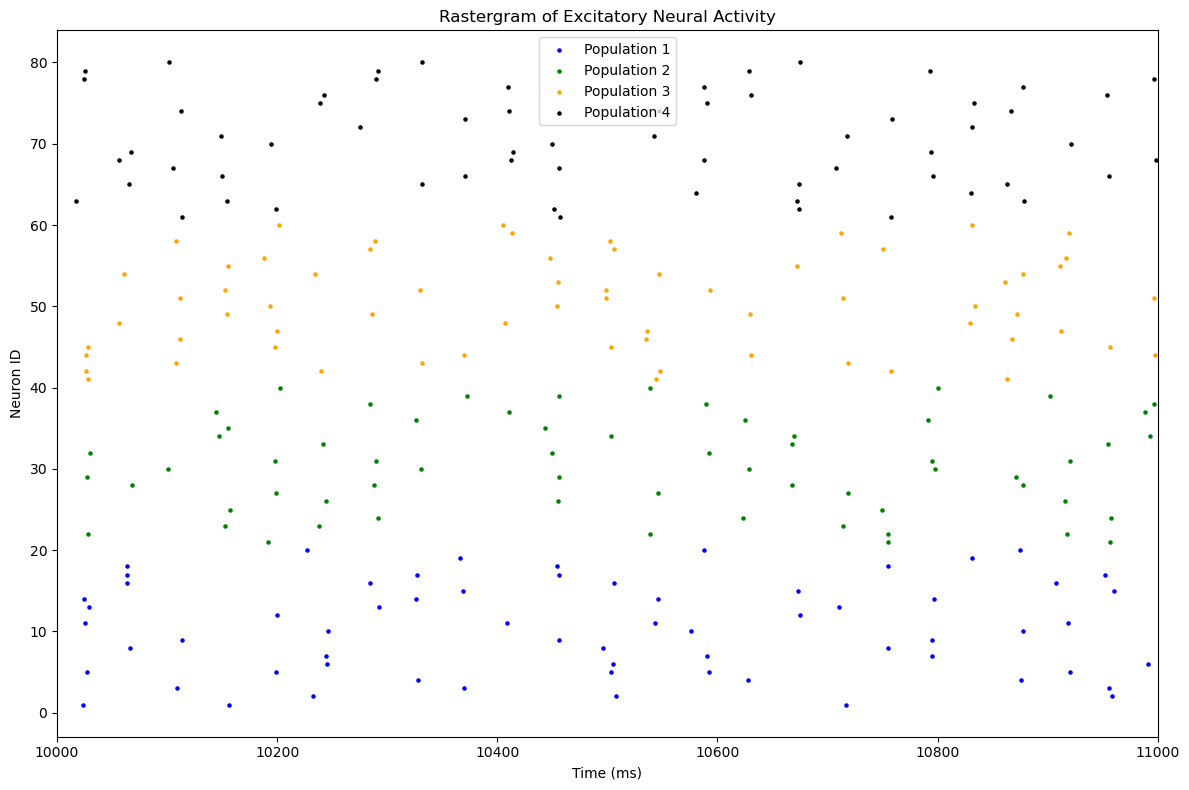

FROM SPIKE-LIKE WAVEFORMS:
--------------------------


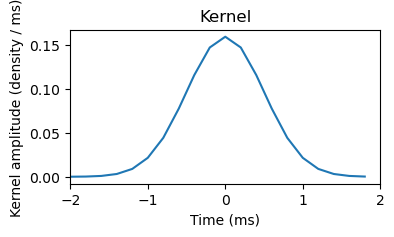

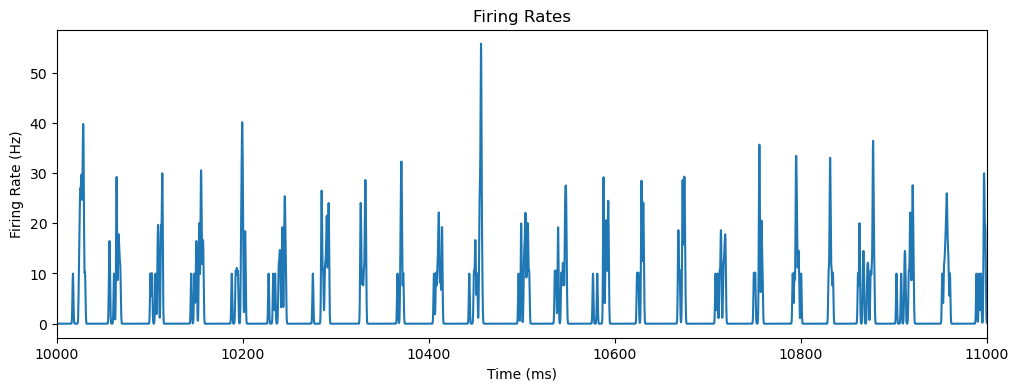

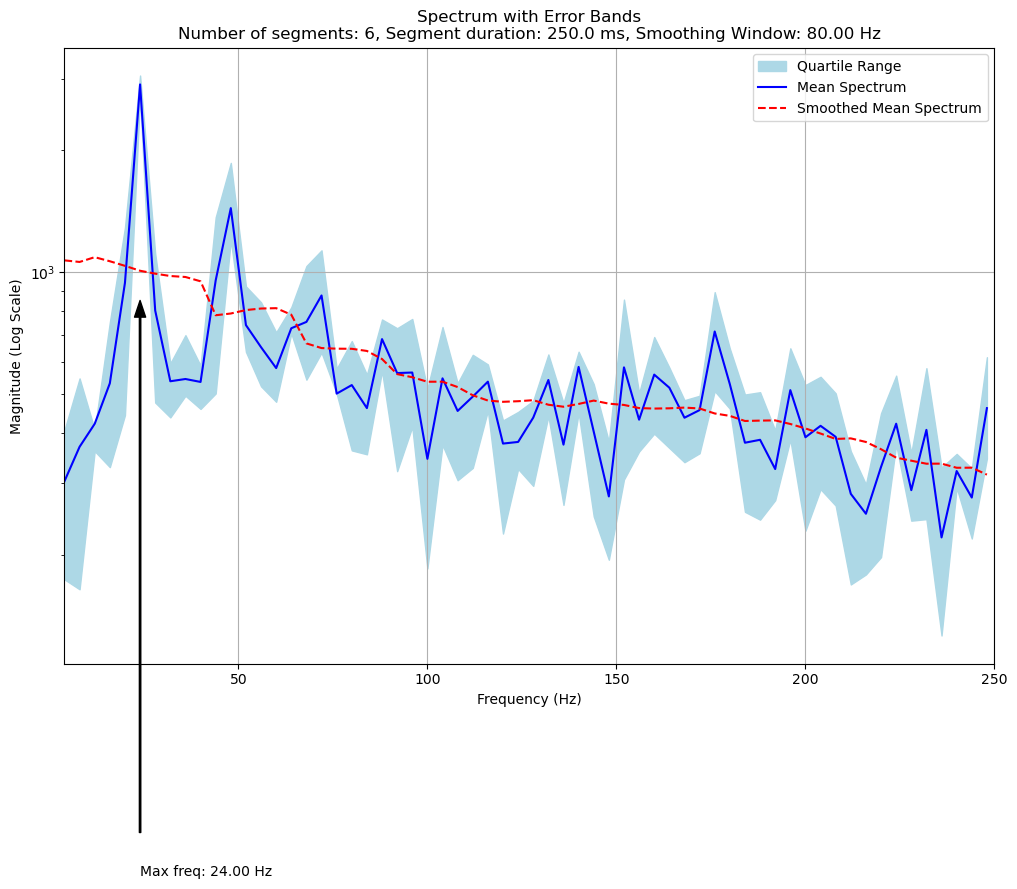

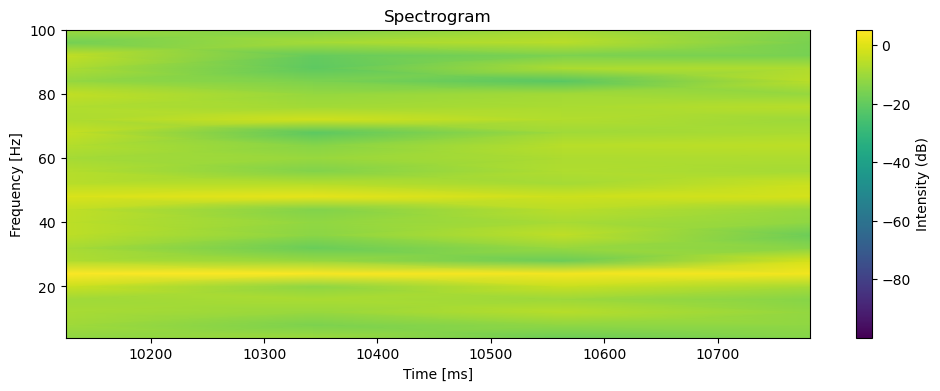

--------------------------
FROM TISSUE-LIKE WAVEFORMS 
--------------------------


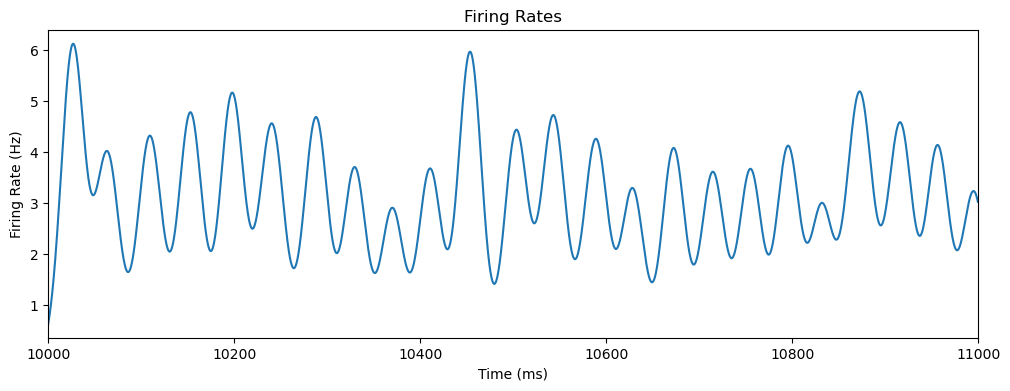

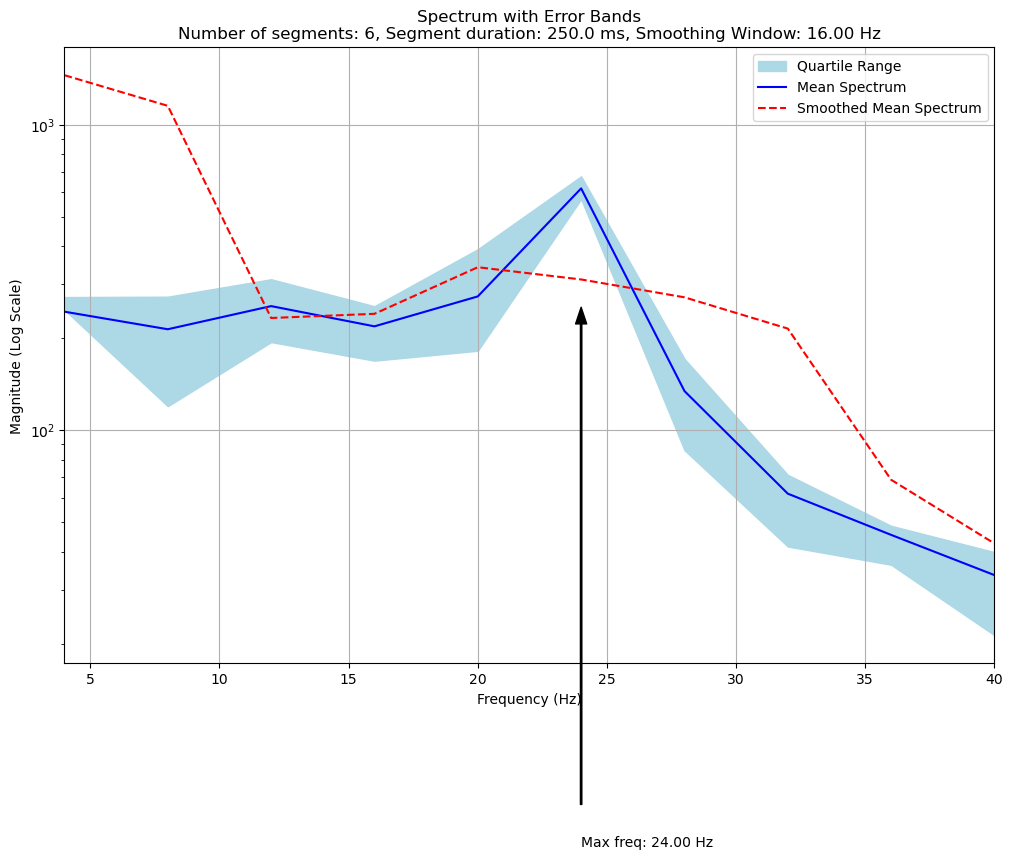

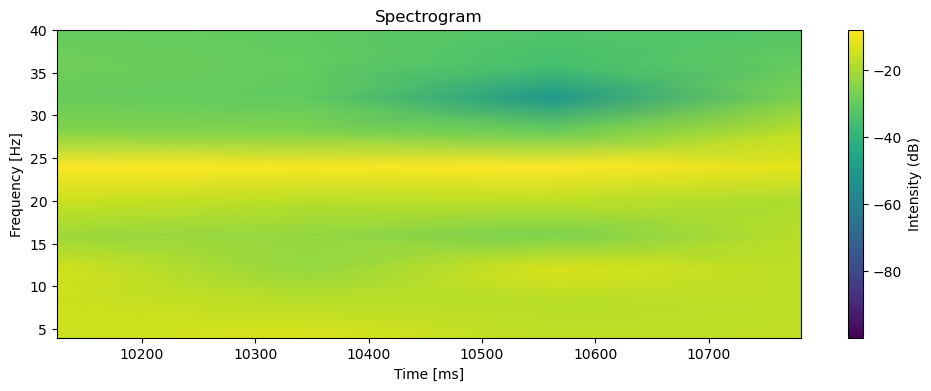

In [8]:
is_verbose=False
#launches all analysis
#produces from both spike-like waveforms and tissue-like responses
#PLEASE use the basic_ and tune_crop_and_plot.yaml to select plots and parameters 
produce_rastegrams_rates_spectra_spectrograms(directories_and_list_of_yamls,\
    nest_pms, crop_pms, plot_pms, analysis_pms, cropped_events, cropped_inh_events, is_verbose)

In [9]:
verbose=False
# loading and printing of info from synaptic matrices
for file_name in list_of_syn_matrix_file_names:
    array_of_dicts=load_syn(file_name, verbose) 

------------------
SYNAPTIC EVOLUTION
Connection group 0
time (ms) 0.0
synapse_model static_synapse_intra_0
  Mean Weight: 0.0000
  Standard Deviation: 0.0000
Connection group 1
time (ms) 0.0
synapse_model static_synapse_intra_1
  Mean Weight: 0.0000
  Standard Deviation: 0.0000
------------------
SYNAPTIC EVOLUTION
Connection group 0
time (ms) 20000.0
synapse_model stdp_synapse_0_0
  Mean Weight: 0.0100
  Standard Deviation: 0.0000
Connection group 1
time (ms) 20000.0
synapse_model stdp_synapse_1_1
  Mean Weight: 0.0100
  Standard Deviation: 0.0000
------------------
SYNAPTIC EVOLUTION
Connection group 0
time (ms) 20000.0
synapse_model stdp_synapse_0_0
  Mean Weight: 0.0100
  Standard Deviation: 0.0000
Connection group 1
time (ms) 20000.0
synapse_model static_synapse_intra_1
  Mean Weight: 0.0000
  Standard Deviation: 0.0000
------------------
SYNAPTIC EVOLUTION
Connection group 0
time (ms) 20000.0
synapse_model stdp_synapse_0_0
  Mean Weight: 0.0100
  Standard Deviation: 0.0000
Conne